In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

In [163]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
dev = "cuda:0"

# History dataset generation

In [4]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [5]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [6]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [7]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

In [8]:
# precipitations
precip = pd.read_csv(config.TR_RAIN_AVG)
precip["quarter_date"] = pd.to_datetime(precip["dt"])

In [9]:
# terrain position index
tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
    .rename(columns={"Unnamed: 0": "frame_id"})

In [10]:
# land cover
landcover = pd.read_csv(config.TR_LANDCOVER)
landcover = pd.pivot_table(
    landcover, 
    index=["frame_id"], 
    columns=["landcover"], 
    values="geometry", 
    aggfunc="sum"
).fillna(0).astype(int)
# convert to percentage
sum_by_frame = landcover.sum(axis=1)
for col in landcover.columns:
    landcover[col] = landcover[col] / sum_by_frame

In [11]:
# past scores
past_scores = pd.read_csv(config.TR_PAST_SCORES)
past_scores["variable"] = pd.to_datetime(past_scores["variable"])

In [12]:
# night lights
night_light = pd.read_csv(config.TR_NIGHT_LIGHT)
night_light["dt"] = pd.to_datetime(night_light["dt"])

## Create grid

In [13]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [14]:
time_grid.shape

(28, 1002, 778)

# Counties data

## Population and density

In [15]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

## Deforestation

In [16]:
frames_counties_defor = pd.merge(
    counties_defor,
    frames_county[["frame_id", "county_id"]],
    on="county_id",
    how="right"
)
frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

In [17]:
# create limits history grid
counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    defor_area = (
        frames_counties_defor[
            frames_counties_defor["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:04,  6.45it/s]


In [18]:
counties_time_grid.shape

(28, 1002, 778)

In [19]:
counties_time_grid.mean(axis=(1, 2))

array([3.64349324, 1.44976199, 0.0549576 , 0.48450147, 2.60491863,
       2.88365836, 0.72031926, 1.33401451, 1.53494971, 0.33965555,
       0.27648444, 1.19631494, 4.66534426, 0.76668875, 0.40991866,
       1.23747129, 5.29401365, 1.63759775, 0.29895257, 1.81006223,
       2.79594653, 0.80019323, 0.39995533, 1.71730521, 5.65761069,
       1.48782054, 0.33267522, 0.85901459])

# Precipitations

In [20]:
# create limits history grid
precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    precip_sum = (
        precip[
            precip["quarter_date"] == dt
        ].set_index("frame_id")["precipitation"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:03,  7.35it/s]


In [21]:
precip_time_grid.shape

(28, 1002, 778)

In [22]:
precip_time_grid.mean(axis=(1, 2))

array([186.20753427, 439.33358713, 702.3223266 , 375.96249359,
       148.5295144 , 413.0688769 , 556.53640863, 399.31430876,
       187.60811386, 429.90324523, 519.214427  , 357.56493712,
       156.44664122, 429.32615398, 496.57244939, 423.21707809,
       154.23955033, 435.23924631, 597.8020921 , 377.38891596,
       197.90357116, 537.16324421, 622.31314606, 363.67691742,
       171.62971464, 437.73113001, 604.32205076, 334.68217645])

# Terrain Position Index

In [23]:
cols = ["mean", "min", "max", "std"]
tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for icol, col in enumerate(cols):
    v = (
        tpi.set_index("frame_id")[col] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

In [24]:
tpi_array.shape

(4, 1002, 778)

In [25]:
tpi_array.max(axis=(1, 2))

array([219.        ,  74.        , 682.        , 381.16196616])

# Land Cover

In [26]:
landcover_categories = [[20], [40, 50], [180]]
landcover_array = np.zeros((len(landcover_categories), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for i, cols in enumerate(landcover_categories):
    v = (
        landcover[cols].sum(axis=1) +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    landcover_array[i, :, :] = v.values.reshape(landcover_array[0, :, :].shape)

In [27]:
landcover_array.shape

(3, 1002, 778)

In [28]:
landcover_array.mean(axis=(1, 2))

array([0.05688078, 0.63904917, 0.01726573])

# Past scores

In [29]:
# create history grid for scores
scores_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    t_scores = (
        past_scores[
            past_scores["variable"] == dt
        ].set_index("frame_id")["value"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    scores_time_grid[t, :, :] = t_scores.values.reshape(scores_time_grid[0, :, :].shape)

28it [00:00, 28.97it/s]


In [30]:
scores_time_grid.shape

(28, 1002, 778)

In [31]:
scores_time_grid.mean(axis=(1,2))

array([0.00019113, 0.01970878, 0.03237829, 0.0303591 , 0.03254027,
       0.04184595, 0.05188484, 0.05343352, 0.05884629, 0.06810746,
       0.06716801, 0.0638416 , 0.06583015, 0.0886549 , 0.09032362,
       0.08556676, 0.08718639, 0.10840274, 0.11322395, 0.10460181,
       0.10748897, 0.11863202, 0.11653463, 0.10905149, 0.10773129,
       0.12110267, 0.12369821, 0.11544868])

# Night lights

In [32]:
# create history grid for scores
night_time_grid = np.zeros((2, len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    avg_light = (
        night_light[
            night_light["dt"] == dt
        ].set_index("frame_id")["avg_light"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    night_time_grid[0, t, :, :] = avg_light.values.reshape(night_time_grid[0, 0, :, :].shape)
    
    max_light = (
        night_light[
            night_light["dt"] == dt
        ].set_index("frame_id")["max_light"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    night_time_grid[1, t, :, :] = max_light.values.reshape(night_time_grid[0, 0, :, :].shape)

28it [00:07,  3.90it/s]


In [33]:
night_time_grid.shape

(2, 28, 1002, 778)

In [34]:
night_time_grid.mean(axis=(2, 3))

array([[0.08905747, 0.06830882, 0.22108746, 0.25371302, 0.23573503,
        0.24402444, 0.21836818, 0.27173093, 0.22944489, 0.22770809,
        0.21122815, 0.18509241, 0.19214316, 0.19492029, 0.24530041,
        0.28831199, 0.29576629, 0.277734  , 0.22200173, 0.27180649,
        0.31246798, 0.27526693, 0.22154229, 0.30725574, 0.26986599,
        0.33866692, 0.27871436, 0.31843935],
       [0.26065561, 0.18529193, 0.36390337, 0.3838    , 0.40839899,
        0.41019799, 0.35407161, 0.41134814, 0.38108935, 0.37483258,
        0.35470058, 0.31806081, 0.35038354, 0.35053503, 0.37943095,
        0.41901216, 0.47711412, 0.44057947, 0.34301519, 0.41183966,
        0.49050084, 0.42313796, 0.35123893, 0.45027927, 0.47900751,
        0.50671131, 0.4252236 , 0.47823331]])

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [35]:
out_condition = "both"  # deforestation | borders | both

bundle_step = 32
patches = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain some deforestation
                patches.append(iframes.index) 

        elif out_condition == "both":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if (out_of_borders_frames < len(iframes)) and (iframes["in_borders"].mean() >= 0.5):
                patches.append(iframes.index) 

100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


In [36]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==len(patches[0]))]

In [37]:
len(patches)

431

In [38]:
patches[0]

Index([  288,   289,   290,   291,   292,   293,   294,   295,   296,   297,
       ...
       49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365],
      dtype='int64', length=4096)

In [39]:
# generate region and check which patches intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 200, 300, 500, 600)

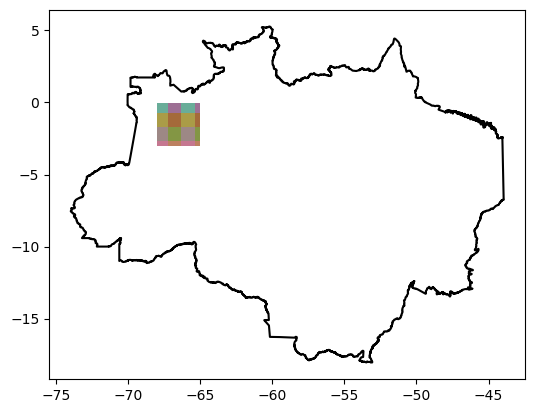

In [40]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0
for i, b in enumerate(patches):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax, color=sns.color_palette()[j%10], alpha=.5)
        j+=1
        if j > 30:
            break
plt.show()

# Train test split

In [41]:
time_grid.shape

(28, 1002, 778)

In [42]:
train_time_idx = range(0,12)
val_time_idx = range(12,20)
test_time_idx = range(20,28)

train_data = time_grid[train_time_idx, :, :]
val_data = time_grid[val_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

# Data Normalization

In [43]:
one_multiplicator_factor = (train_data <= 1e-7).sum() / (train_data > 1e-7).sum()

In [44]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

In [45]:
counties_time_grid = (counties_time_grid-counties_time_grid[train_time_idx, :, :].mean()) / counties_time_grid[train_time_idx, :, :].std()

In [46]:
precip_time_grid = (precip_time_grid-precip_time_grid[train_time_idx, :, :].mean()) / precip_time_grid[train_time_idx, :, :].std()

In [47]:
for i in range(tpi_array.shape[0]):
    tpi_array[i, :, :] = (tpi_array[i, :, :] - tpi_array[i, :, :].mean()) / tpi_array[i, :, :].std()

In [48]:
for i in [0, 1]:
    night_time_grid[i, :, :, :] = (
        (
            night_time_grid[i, :, :, :] - 
            night_time_grid[i, train_time_idx, :, :].mean()
        ) / night_time_grid[i, train_time_idx, :, :].std()
    )

# Loss function

In [49]:
def WeightedBinaryCrossEntropy(target, prediction):
    return -(target*prediction.log() + (1-target)*((1-prediction).log()))

In [50]:
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss().to(dev)

# Dataset & Dataloaders

In [51]:
len(patches) * (time_grid.shape[0] - 4)

10344

In [52]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx, 
        county_data=None, 
        county_defor=None,
        precip_data=None,
        tpi_data=None,
        landcover_data=None,
        scores_data=None,
        night_data=None
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.precip_data = precip_data
        self.tpi_data = tpi_data
        self.landcover_data = landcover_data
        self.scores_data = scores_data
        self.night_data = night_data

        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]

        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.county_defor is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_defor[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.precip_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.precip_data[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.tpi_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.tpi_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.landcover_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.landcover_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.scores_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.scores_data[
                    [idx_time+self.autor_window],
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.night_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.night_data[
                    :,
                    idx_time+self.autor_window-1,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        data = torch.tensor(input_matrix).float().to(dev)

        # get output
        labels = np.zeros(
            (
                2, 
                idx_frames["x"].max()-idx_frames["x"].min() + 1, 
                idx_frames["y"].max()-idx_frames["y"].min() + 1
            )
        )
        target_idx = np.where(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        )
        labels[0, :, :] = 1
        labels[0, :, :][target_idx] = 0
        labels[1, :, :][target_idx] = 1
        labels = torch.tensor(labels).float().to(dev)
        return data, labels

In [53]:
train_data.shape, val_data.shape, test_data.shape

((12, 1002, 778), (8, 1002, 778), (8, 1002, 778))

In [54]:
# patches_sample_train = [patches[i] for i in np.random.choice(range(len(patches)), 100, replace=False)]
# patches_sample_test = [patches[i] for i in np.random.choice(range(len(patches)), 10, replace=False)]

# patches_sample_train = patches[:1]
# patches_sample_test = patches[1:2]

patches_sample_train = patches
patches_sample_val = patches

In [55]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid
    ),
    batch_size=64,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_val, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid
    ),
    batch_size=1000,
    shuffle=True
)

In [56]:
trainloader.__len__(), valloader.__len__()

(54, 2)

# Baseline Model

Evaluate error without any model

In [84]:
# baseline: all zero
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    break
    base_train_err += ce_loss(input=y_pred, target=labels)
base_train_err = base_train_err / len(trainloader)

print(f"Baseline Error (Train) = {base_train_err:.6f}")

Baseline Error (Train) = 0.000000


In [58]:
base_val_err = 0
for inputs, labels in valloader:
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    base_val_err += ce_loss(input=y_pred, target=labels)
base_val_err = base_val_err / len(valloader)
print(f"Baseline Error (Validation) = {base_val_err:.6f}")

Baseline Error (Validation) = 0.335458


# Model Init

In [59]:
import torch.optim as optim
import segmentation_models_pytorch as smp

In [60]:
in_channels = 4+2+4+4+4+3+1+2
in_channels

24

In [61]:
# model = smp.Unet(
#     encoder_name="resnet34",
#     in_channels=in_channels,
#     classes=2,
# )
# optimizer = optim.Adam(model.parameters())

In [62]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    in_channels=in_channels, 
    classes=2,
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [63]:
# use gpu
model = model.to(dev)

In [89]:
model.load_state_dict(torch.load(r"DeepLabV3+.pt"))

<All keys matched successfully>

In [90]:
print(model)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(24, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [91]:
# check for inifinty error
train_err = 0
for inputs, labels in trainloader:
    y_pred = model(inputs).detach().to(dev)
    train_err += ce_loss(input=y_pred, target=labels)
    # train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
    print(train_err)
    if train_err > 1e9:
        break

tensor(0.0553, device='cuda:0')
tensor(0.1001, device='cuda:0')
tensor(0.1533, device='cuda:0')
tensor(0.2013, device='cuda:0')
tensor(0.2717, device='cuda:0')
tensor(0.3419, device='cuda:0')
tensor(0.3854, device='cuda:0')
tensor(0.4534, device='cuda:0')
tensor(0.5165, device='cuda:0')
tensor(0.5735, device='cuda:0')
tensor(0.6287, device='cuda:0')
tensor(0.6869, device='cuda:0')
tensor(0.7518, device='cuda:0')
tensor(0.7978, device='cuda:0')
tensor(0.8652, device='cuda:0')
tensor(0.9345, device='cuda:0')
tensor(0.9924, device='cuda:0')
tensor(1.0516, device='cuda:0')
tensor(1.0986, device='cuda:0')
tensor(1.1510, device='cuda:0')
tensor(1.2222, device='cuda:0')
tensor(1.2746, device='cuda:0')
tensor(1.3379, device='cuda:0')
tensor(1.3937, device='cuda:0')
tensor(1.4410, device='cuda:0')
tensor(1.4909, device='cuda:0')
tensor(1.5408, device='cuda:0')
tensor(1.6157, device='cuda:0')
tensor(1.6793, device='cuda:0')
tensor(1.7374, device='cuda:0')
tensor(1.7860, device='cuda:0')
tensor(1

# Train loop

In [67]:
# train loop
model.epoch = 0
model.errs = []

In [68]:
def evaluate_model(model, dataloader):
    err = 0
    for inputs, labels in dataloader:
        y_pred = model(inputs).detach()
        err += ce_loss(input=y_pred, target=labels)
    err = err / len(dataloader)

    return err

In [69]:
def run_epoch():
    model.epoch += 1
    print(f"\nEpoch {model.epoch}")
    
    train_err = 0
    for inputs, labels in tqdm(trainloader):
        y_pred = model(inputs)
        loss = ce_loss(input=y_pred, target=labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_err += loss.detach()
    train_err = train_err / len(trainloader)
    
    return train_err


def train(n_epochs):
    for epoch in range(n_epochs):
        
        # train for 1 epoch and compute error
        train_err = run_epoch()

        # compute validation error and save history            
        val_err = evaluate_model(model, valloader)
        model.errs.append([train_err, val_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Validation Loss = {val_err:.6f}")

In [70]:
train(30)


Epoch 1


100%|██████████| 54/54 [00:14<00:00,  3.75it/s]


Epoch 1: Train Loss = 0.409587 | Validation Loss = 0.247303

Epoch 2


100%|██████████| 54/54 [00:13<00:00,  3.94it/s]


Epoch 2: Train Loss = 0.168018 | Validation Loss = 0.136503

Epoch 3


100%|██████████| 54/54 [00:13<00:00,  3.95it/s]


Epoch 3: Train Loss = 0.111913 | Validation Loss = 0.115455

Epoch 4


100%|██████████| 54/54 [00:13<00:00,  3.96it/s]


Epoch 4: Train Loss = 0.093162 | Validation Loss = 0.104177

Epoch 5


100%|██████████| 54/54 [00:13<00:00,  4.10it/s]


Epoch 5: Train Loss = 0.082289 | Validation Loss = 0.095674

Epoch 6


100%|██████████| 54/54 [00:13<00:00,  3.96it/s]


Epoch 6: Train Loss = 0.077328 | Validation Loss = 0.095014

Epoch 7


100%|██████████| 54/54 [00:13<00:00,  3.95it/s]


Epoch 7: Train Loss = 0.073260 | Validation Loss = 0.091343

Epoch 8


100%|██████████| 54/54 [00:13<00:00,  4.03it/s]


Epoch 8: Train Loss = 0.070495 | Validation Loss = 0.089181

Epoch 9


100%|██████████| 54/54 [00:13<00:00,  4.02it/s]


Epoch 9: Train Loss = 0.068610 | Validation Loss = 0.088987

Epoch 10


100%|██████████| 54/54 [00:13<00:00,  4.11it/s]


Epoch 10: Train Loss = 0.067236 | Validation Loss = 0.088989

Epoch 11


100%|██████████| 54/54 [00:13<00:00,  4.00it/s]


Epoch 11: Train Loss = 0.066347 | Validation Loss = 0.086105

Epoch 12


100%|██████████| 54/54 [00:13<00:00,  3.91it/s]


Epoch 12: Train Loss = 0.064854 | Validation Loss = 0.087239

Epoch 13


100%|██████████| 54/54 [00:13<00:00,  3.88it/s]


Epoch 13: Train Loss = 0.064081 | Validation Loss = 0.085765

Epoch 14


100%|██████████| 54/54 [00:13<00:00,  3.87it/s]


Epoch 14: Train Loss = 0.063029 | Validation Loss = 0.085466

Epoch 15


100%|██████████| 54/54 [00:14<00:00,  3.85it/s]


Epoch 15: Train Loss = 0.062471 | Validation Loss = 0.085797

Epoch 16


100%|██████████| 54/54 [00:13<00:00,  3.92it/s]


Epoch 16: Train Loss = 0.062024 | Validation Loss = 0.084858

Epoch 17


100%|██████████| 54/54 [00:13<00:00,  3.92it/s]


Epoch 17: Train Loss = 0.061194 | Validation Loss = 0.085231

Epoch 18


100%|██████████| 54/54 [00:13<00:00,  3.90it/s]


Epoch 18: Train Loss = 0.060715 | Validation Loss = 0.084008

Epoch 19


100%|██████████| 54/54 [00:13<00:00,  3.89it/s]


Epoch 19: Train Loss = 0.060309 | Validation Loss = 0.085633

Epoch 20


100%|██████████| 54/54 [00:13<00:00,  3.87it/s]


Epoch 20: Train Loss = 0.060083 | Validation Loss = 0.086493

Epoch 21


100%|██████████| 54/54 [00:13<00:00,  4.04it/s]


Epoch 21: Train Loss = 0.059626 | Validation Loss = 0.083972

Epoch 22


100%|██████████| 54/54 [00:13<00:00,  3.98it/s]


Epoch 22: Train Loss = 0.059287 | Validation Loss = 0.084604

Epoch 23


100%|██████████| 54/54 [00:13<00:00,  4.03it/s]


Epoch 23: Train Loss = 0.058663 | Validation Loss = 0.084165

Epoch 24


100%|██████████| 54/54 [00:13<00:00,  4.00it/s]


Epoch 24: Train Loss = 0.058489 | Validation Loss = 0.083800

Epoch 25


100%|██████████| 54/54 [00:14<00:00,  3.85it/s]


Epoch 25: Train Loss = 0.058022 | Validation Loss = 0.084667

Epoch 26


100%|██████████| 54/54 [00:13<00:00,  3.95it/s]


Epoch 26: Train Loss = 0.057849 | Validation Loss = 0.085181

Epoch 27


100%|██████████| 54/54 [00:13<00:00,  3.86it/s]


Epoch 27: Train Loss = 0.057354 | Validation Loss = 0.086016

Epoch 28


100%|██████████| 54/54 [00:13<00:00,  3.92it/s]


Epoch 28: Train Loss = 0.057305 | Validation Loss = 0.084426

Epoch 29


100%|██████████| 54/54 [00:13<00:00,  3.97it/s]


Epoch 29: Train Loss = 0.057053 | Validation Loss = 0.083728

Epoch 30


100%|██████████| 54/54 [00:13<00:00,  4.03it/s]


Epoch 30: Train Loss = 0.056600 | Validation Loss = 0.084623


Better than baseline?

In [71]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_val_err)
)

(-0.27317606570933556, -0.2509159315031565)

Learning curve

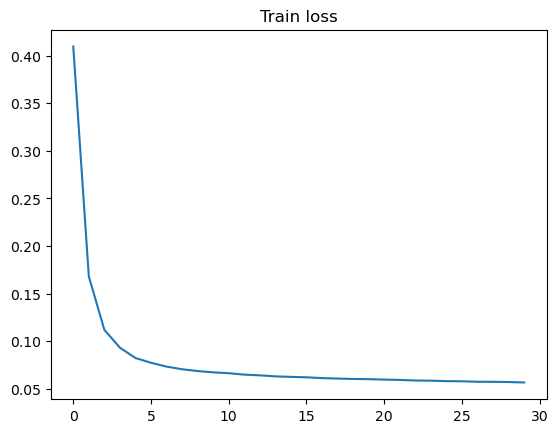

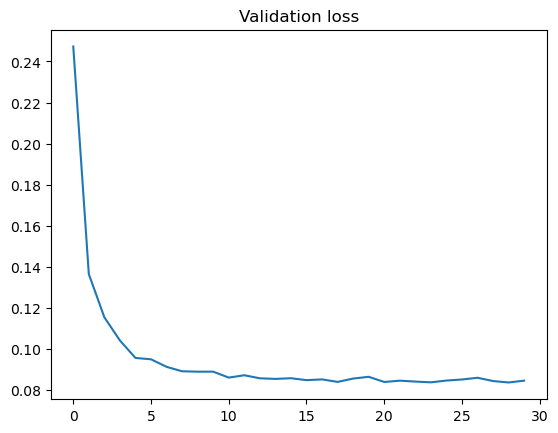

In [72]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.title("Train loss")
plt.show()
plt.plot([float(e[1]) for e in model.errs])
plt.title("Validation loss")
plt.show()

# Confusion Matrix

In [99]:
# softmax function will be needed
softmax_ = nn.Softmax(dim=1)

## Train

In [141]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in trainloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [142]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

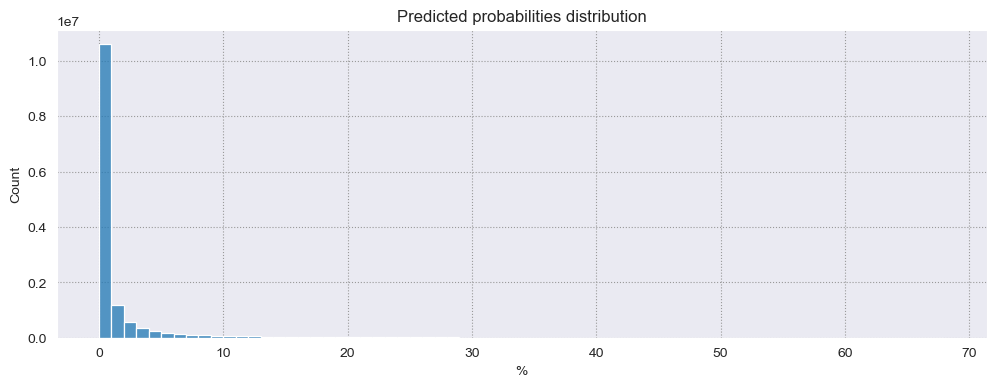

In [164]:
# get predictions distribution
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(100*y_pred, binwidth=1, ax=ax)
ax.set_title("Predicted probabilities distribution")
ax.set_xlabel("%")
plt.show()

In [139]:
# select probability treshold
from sklearn.metrics import f1_score

scores = []
for p_treshold in tqdm(range(1, 21)):
    scores.append(
        f1_score(
            y_true, 
            y_pred > p_treshold / 100
        )
    )

100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


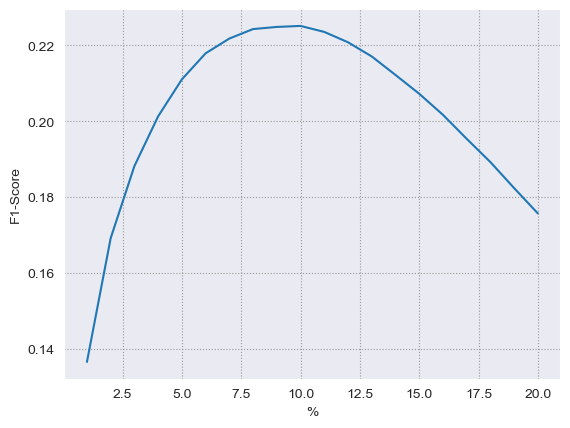

In [165]:
g = sns.lineplot(x=range(1, 21), y=scores)
g.set_xlabel("%")
g.set_ylabel("F1-Score")
plt.show()

In [166]:
# apply confusion matrix with probability treshold
p_treshold = 0.1

from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.96579345, 0.03420655],
       [0.48358786, 0.51641214]])

In [167]:
f1_score(
    y_true, 
    y_pred > p_treshold
)

0.29065457546464096

# Prediction example

In [168]:
def get_sample(min_area=0.1, dataloader=trainloader):
    for input_, truth in dataloader:
        batches = list(range(truth.shape[0])) 
        shuffle(batches)
        for idx_batch in batches:
            if truth[idx_batch, 1, :, :].mean() > min_area:
                return input_, truth, idx_batch

In [169]:
input_, truth, idx_batch = get_sample(0.01, trainloader)

pred = model(input_)

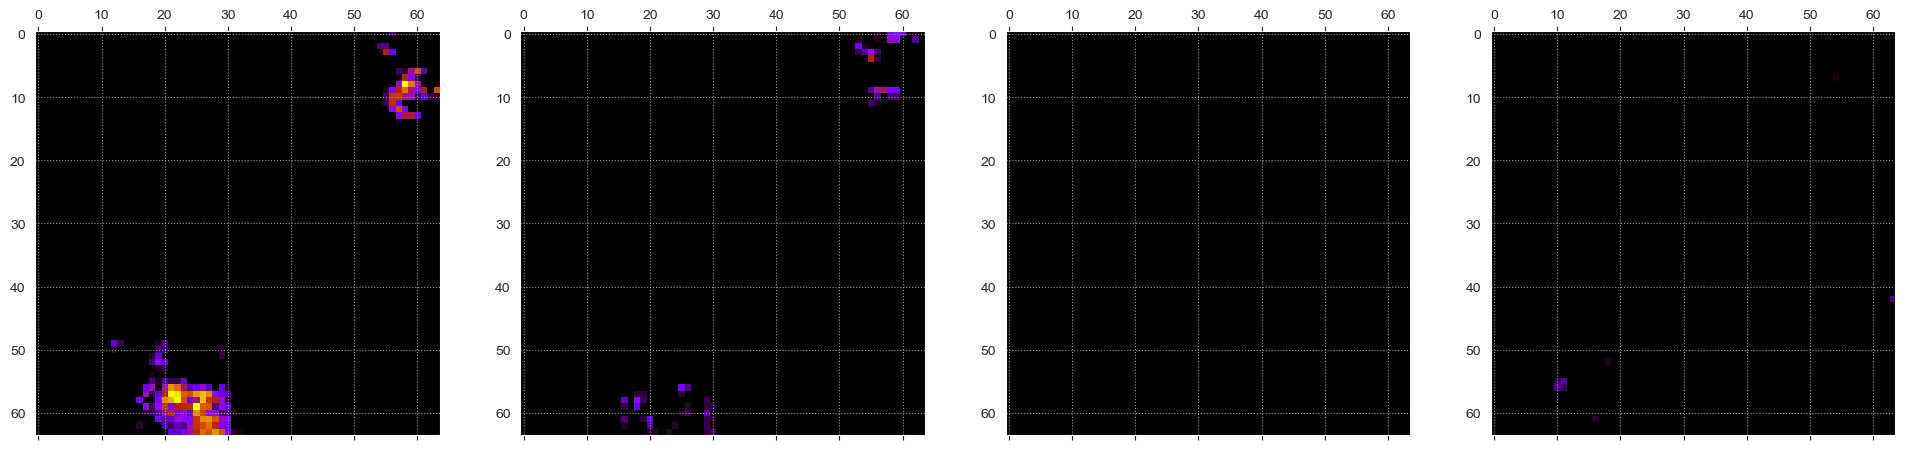

In [170]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[idx_batch, i, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_14064\3523613288.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


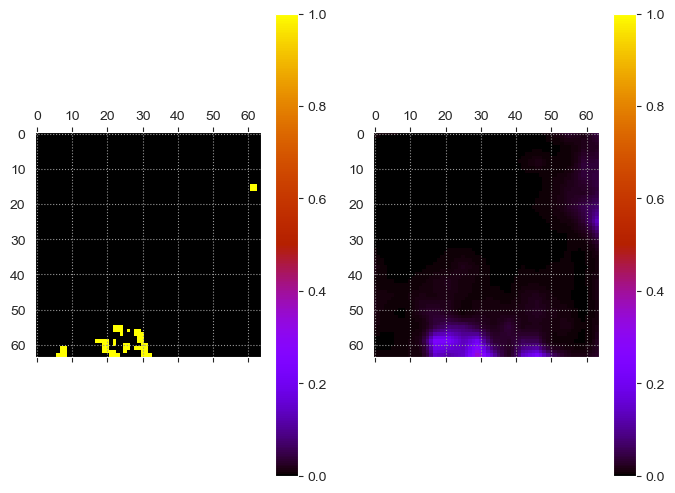

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
m1 = ax[0].matshow(truth[idx_batch, 1, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[1].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [78]:
torch.save(model.state_dict(), r"DeepLabV3+.pt")